In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import signal
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

dr = '../Recordings/Speller/'
file_1 = 'run_05.xdf'
file_2 = 'run_06.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
print(data)

{'run': [{'data': array([[ 2.29074759e+04, -1.59277860e+04, -1.02147472e+01, ...,
         8.12103696e+03,  2.61132748e+04,  4.21989759e+04],
       [ 2.29031843e+04, -1.59217287e+04, -7.51018614e+00, ...,
         8.11833240e+03,  2.61158006e+04,  4.21876436e+04],
       [ 2.29091523e+04, -1.59338657e+04, -1.84178374e+01, ...,
         8.11877944e+03,  2.60890902e+04,  4.22018593e+04],
       ...,
       [ 1.61976610e+04, -1.46137046e+04, -6.80588267e+02, ...,
        -4.56020290e+02,  2.92709058e+04,  3.56824590e+04],
       [ 1.62064229e+04, -1.46176162e+04, -6.83337531e+02, ...,
        -4.55819125e+02,  2.92525550e+04,  3.56954900e+04],
       [ 1.62123685e+04, -1.46172586e+04, -6.82488165e+02, ...,
        -4.52533418e+02,  2.92512586e+04,  3.57030449e+04]]), 'time_stamps': array([1889.88782915, 1889.89182915, 1889.89582915, ..., 2563.93983393,
       2563.94383393, 2563.94783393]), 'aux': array([[ 417.,    4., 1017.],
       [ 417.,    4., 1020.],
       [ 417.,    3., 1019.],
 

In [3]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel else 'Time (ms)'
    ylabel = ylabel if ylabel else r'Amplitude'
    title = title if title else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend(loc='upper left', fancybox=True)
    
    return fig, ax

def plot_epochs(ch_epochs, xlabel='Times (ms)', ylabel='Epochs', title='Epoch Comparison', tmin=None, tmax=None):
    fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    if tmin == None or tmax == None:
        tmin = 0
        tmax = ch_epochs.shape[-1]
    extent = [tmin, tmax, 0, len(ch_epochs)]
    
    plot = ax.matshow(ch_epochs, interpolation='nearest', origin='lower', aspect='auto', extent=extent)

    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axis('auto')
    ax.axis('tight')
    ax.axvline(0, color='k', linewidth=1, linestyle='--')

    cbar = fig.colorbar(plot)
    cbar.ax.set_ylabel(r'Amplitude ($\mu$V)', rotation=270, labelpad=12)
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [4]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)


def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


def prepare_epochs(epochs, sample_rate, baseline_duration=100):
    # epochs should be 3D, (event, samples, channels)
    # baseline duration, in ms
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
#         temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)

# ================
# Speller Specific
# ================
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

answer_key = {}
for i, row in enumerate(ltr_key):
    for j, ch in enumerate(row):
        answer_key[ch] = [i,j+len(ltr_key)]

In [5]:
# Use mastoid as ref, then avg-ref the second mastoid
# Place the ground at AFz
channels = ['M2', 'Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'Oz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

# assigning data... a bit redundant but the hope is to help make the pipelining easier
run_1 = data['run'][0]
# run_2 = data['run'][1]

r1_eeg = run_1['data']
r1_eeg_ts = run_1['time_stamps']
r1_aux = run_1['aux']
r1_aux_ts = run_1['aux_time_stamps']
r1_markers = run_1['markers']
r1_markers_ts = run_1['marker_time_stamps']


# SLOW!!! There is probably a better way to do this.
def de_ref_all(data):
    # data should be (n_samples, n_channels)
    # returns de_ref data plus the rebuilt online ref
    # (n_samples, org_ref + n_channels)
    ref = np.zeros((len(data), len(data[0])+1))
    for i, sample in enumerate(data):
        y = sample
        y = np.concatenate(([sum(y)], y))
        chs = len(sample)
        a = np.identity(chs).astype(float)
        ref_col = np.ones(chs).astype(float) * -1.0
        a = np.hstack((ref_col[None].T, a))
        ref_row = np.ones(chs+1).astype(float)
        ref_row[0] = -chs
        a = np.vstack((ref_row[None], a))
        x = np.linalg.solve(a,y)
        ref[i] = x
        
    return ref

def rebuild_online_ref(data):
    # data should be (n_samples, n_channels)
    x = de_ref_all(data)
    return x[:,0]
    

# re-reference with mastoid average
# M1 is the original online reference, so to re-ref with (M1+M2)/2
# a' = a - r/2 where r = M2
re_ref = r1_eeg - r1_eeg[:,0,None]/2.0

# remove M2 from channels
r1_eeg = re_ref[:,1:]
channels = channels[1:]

del re_ref

r1_eeg = filter_eeg(r1_eeg, 250, [1.,20.] )
# r2_eeg = filter_eeg(r2_eeg, 250, [1.,20.] )

# convert times to int milliseconds
r1_eeg_ts = (r1_eeg_ts*1000).astype(int)
# r2_eeg_ts = (r2_eeg_ts*1000).astype(int)
r1_aux_ts = (r1_aux_ts*1000).astype(int)
# r2_aux_ts = (r2_aux_ts*1000).astype(int)
r1_markers_ts = (r1_markers_ts*1000).astype(int)
# r2_markers_ts = (r2_markers_ts*1000).astype(int)

print(channels)
pz = channels.index('Pz')
oz = channels.index('Oz')
fp1 = channels.index('Fp1')

['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'Oz', 'Fp1']


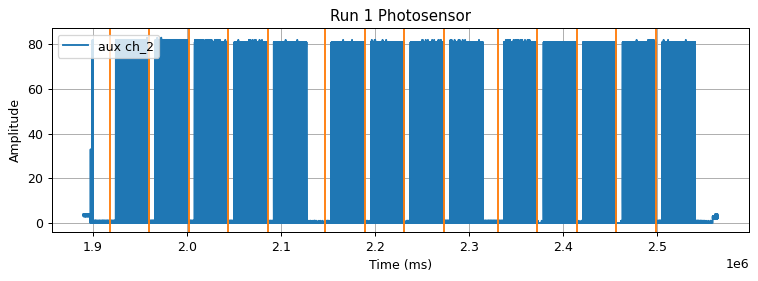

In [6]:
fig, ax = plot_time_series(
    X = r1_aux_ts,
    Y = r1_aux[:,1:2],
    labels = aux_chs[1:2],
    title='Run 1 Photosensor'
)
add_markers_to_plot(r1_markers, r1_markers_ts, fig, ax)

In [7]:
# HANDLE PHOTOSENSORS
# -------------------
# scaling for dim display
# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps

def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

def divide_markers(markers):
    # rc = row and column
    marker_collection = []
    target_collection = []
    y_collection = []
    for marker_arr in markers:
        marker = marker_arr[0]
        if '[' in marker:
            lbl = marker.split('[')[1].split(']')[0]
            target_collection.append(lbl)
            marker_collection.append([])
            y_collection.append([])
        elif marker.isnumeric():
            marker = int(marker)
            marker_collection[-1].append(marker)
            key = answer_key[target_collection[-1]]
            if marker in key:
                y_collection[-1].append(1)
            else:
                y_collection[-1].append(0)
                
    
    return target_collection, np.array(marker_collection), np.array(y_collection)

def sync_sensor_to_markers(sensor_ts, stim_markers, targets):
    len_a = len(sensor_ts.flatten())
    len_b = len(stim_markers.flatten())
    len_c = len(targets.flatten())
    assert len_a == len_b == len_c, 'Invalid Operation' # dimensions must match
    
    synced = np.vstack((sensor_ts.flatten(),
                        stim_markers.flatten(),
                        targets.flatten()))
    return synced.T

# scaling
# max_run1 = max(r1_aux[:,1])
# max_run2 = max(r2_aux[:,1])
# scaler = max_run2/max_run1
# r1_aux[:,1] = r1_aux[:,1] * scaler


PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)
# r2_photosensor_onsets = get_ts_for_on_rise_threshold(r2_aux[:,1], r2_aux_ts, PHOTO_SENSOR_THRESHOLD)

# TODO: automate this!
# There are 2 test sensor blinks that we can get rid of
r1_photosensor_onsets = r1_photosensor_onsets[2:]
# r2_photosensor_onsets = r2_photosensor_onsets[3:]

r1_target_ltr, r1_stim_markers, r1_y = divide_markers(r1_markers)
print(r1_target_ltr)
# r2_target_ltr, r2_stim_markers, r2_y = divide_markers(r2_markers)

r1_events = sync_sensor_to_markers(r1_photosensor_onsets, r1_stim_markers, r1_y)
# r2_events = sync_sensor_to_markers(r2_photosensor_onsets, r2_stim_markers, r2_y)

print(r1_events[:5])
print(r1_events.shape)

['C', 'Y', 'T', 'O', 'N', 'Z', 'E', 'R', 'O', 'P', 'H', 'A', 'S', 'E']
[[1924315       8       1]
 [1924495       0       1]
 [1924683       6       0]
 [1924863       7       0]
 [1925047       3       0]]
(2520, 3)


In [8]:
# TRUNCATE and NORMALIZE
def get_session_mask(eeg_ts, markers_ts, events):
    first_photosensor_time = events[0,0]
    first_marker_time = markers_ts[1] # skip the first...its too early and not useful
    last_photosensor_time = events[-1,0]
    last_marker_time = markers_ts[-1]
    session_win_start = min(first_photosensor_time, first_marker_time) - 1000
    session_win_stop = max(last_photosensor_time, last_marker_time) + 1000
    print(f'session: {session_win_start} to {session_win_stop}')
    mask = (eeg_ts >= session_win_start) & (eeg_ts <= session_win_stop)
    return mask
    
r1_mask = get_session_mask(r1_eeg_ts, r1_markers_ts, r1_events)
# r2_mask = get_session_mask(r2_eeg_ts, r2_markers_ts, r2_events)

r1_eeg = r1_eeg[r1_mask]
# r2_eeg = r2_eeg[r2_mask]
r1_eeg_ts = r1_eeg_ts[r1_mask]
# r2_eeg_ts = r2_eeg_ts[r2_mask]

# normalize
def zero_and_normalize(eeg_data):
    eeg_data = eeg_data - np.mean(eeg_data, 0)
    eeg_data = eeg_data / np.std(eeg_data, 0)
    return eeg_data

r1_eeg = zero_and_normalize(r1_eeg)
# r2_eeg = zero_and_normalize(r2_eeg)

session: 1912949 to 2540843


In [9]:
# Epoch durations in ms
PRE_STIM = 100
POST_STIM = 800

SAMPLE_RATE = 250.0 # Hz

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)
    
# r2_epochs = []
# for time in r2_photosensor_onsets:
#     # get epoch based on time stamp
#     epoch = get_epoch(r2_eeg, r2_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
#     r2_epochs.append(epoch)
    

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
# r2_epochs = prepare_epochs(r2_epochs, SAMPLE_RATE)
r1_epochs_ts = r1_photosensor_onsets
# r2_epochs_ts = r2_photosensor_onsets

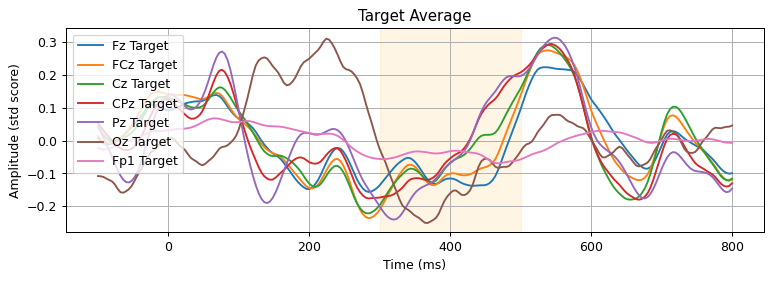

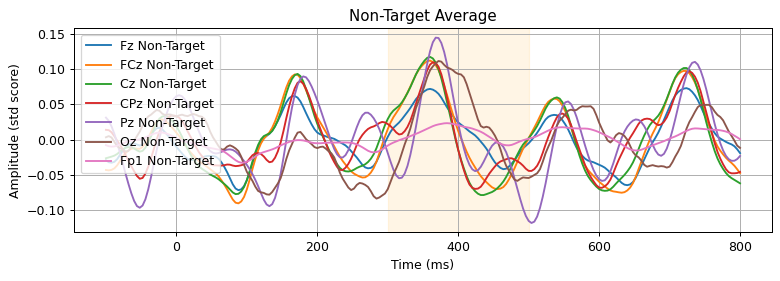

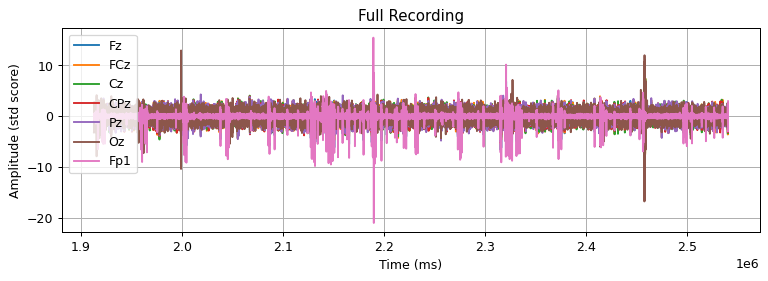

In [10]:
y = r1_events[:,2]
target_epochs = r1_epochs[y == 1]
non_target_epochs = r1_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r1_epochs.shape[1])]

target_epoch_avg = np.mean(target_epochs, axis=0)
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)

g_labels = [ch + ' Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = g_labels,
    ylabel=r'Amplitude (std score)',
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Non-Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = g_labels,
    ylabel=r'Amplitude (std score)',
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg,
    labels = g_labels,
    ylabel=r'Amplitude (std score)',
    title=f'Full Recording'
)
# _ = ax.axvspan(300, 500, color='orange', alpha=0.1)

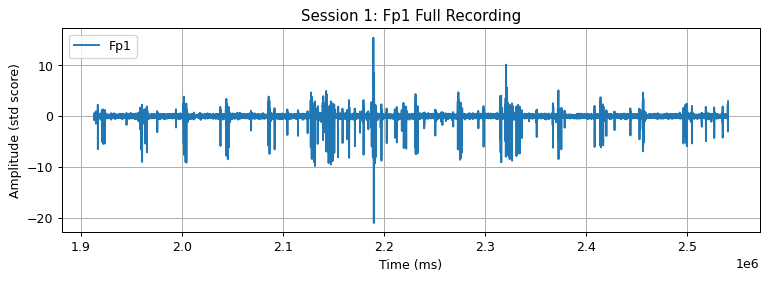

In [11]:
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    ylabel=r'Amplitude (std score)',
    title=f'Session 1: Fp1 Full Recording'
)

In [12]:
def get_blinks(data, data_ts, ch, blink_dev_thresh=2.0):
    ch_data = data[:,ch]
    ch_mean = ch_data.mean()
    ch_std = ch_data.std()
    ch_dev = np.abs((ch_data - ch_mean) / ch_std)
    blink_mask = ch_dev > blink_dev_thresh
    blink_int = blink_mask.astype(int)
    blinks = []
    for i, val in enumerate(blink_int):
        if i == 0:
            continue

        prev = blink_int[i-1]
        if val != prev:
            if val == 1:
                blinks.append([data_ts[i]])
            else:
                blinks[-1].append(data_ts[i])
                
    if len(blinks[-1]) < 2:
        blinks[-1].append(data_ts[-1])
        
    return np.array(blinks), blink_mask

r1_blinks, _ = get_blinks(r1_eeg, r1_eeg_ts, fp1, 1.5)
# r2_blinks, _ = get_blinks(r2_eeg, r2_eeg_ts, fp1, 1.5)

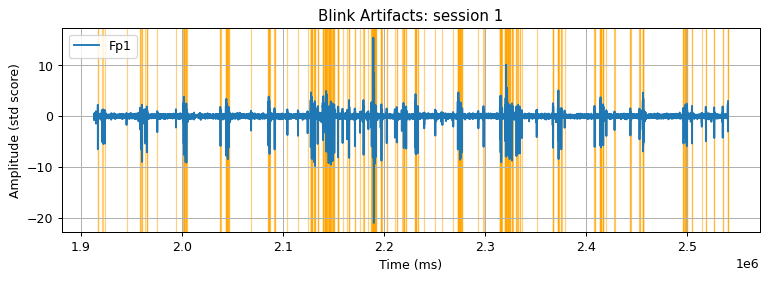

In [13]:
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    ylabel=r'Amplitude (std score)',
    title=f'Blink Artifacts: session 1'
)
for blink in r1_blinks:
    _ = ax.axvspan(blink[0], blink[1], color='orange', alpha=0.5)

In [14]:
def get_bad_epochs_indices(epochs_ts, blinks):    
    count = 0
    bad_epoch_i = []
    for i, time in enumerate(epochs_ts):
        e_start = time - PRE_STIM
        e_stop = time + POST_STIM
        a = (blinks[:,0] >= e_start) & (blinks[:,0] < e_stop)
        overlap = np.count_nonzero(a)
        if overlap == 0:
            b = (blinks[:,1] > e_start) & (blinks[:,1] <= e_stop)
            overlap = np.count_nonzero(b)

        if overlap > 0:
            bad_epoch_i.append(i)
            count += 1
            
    print(f'{count} contaminated epochs!')
    return np.array(bad_epoch_i)

r1_bad_epochs = get_bad_epochs_indices(r1_epochs_ts, r1_blinks)
print(r1_bad_epochs)
print(r1_events[r1_bad_epochs, 2])

picks = np.ones(len(r1_epochs),np.bool)
picks[r1_bad_epochs] = 0

259 contaminated epochs!
[ 104  105  106  107  108  175  176  177  178  179  226  227  228  229
  230  321  322  323  324  325  510  511  512  513  514  515  516  538
  539  631  632  633  634  635  719  780  781  782  783  784  834  835
  836  837  838  839  884  885  886  887  899  901  902  903  904  905
  906  907  925  926  927  928  929  948  949  950  951  952  957  958
  959  960  961  962  963  987  988  989  990  991  992 1014 1015 1016
 1017 1018 1031 1032 1033 1034 1035 1036 1037 1057 1058 1059 1060 1061
 1071 1072 1073 1074 1075 1076 1077 1078 1079 1083 1084 1085 1086 1087
 1088 1089 1090 1091 1113 1114 1115 1116 1117 1118 1156 1157 1158 1159
 1160 1165 1166 1167 1168 1169 1170 1191 1192 1193 1194 1195 1200 1201
 1202 1203 1204 1205 1206 1213 1214 1215 1216 1217 1218 1259 1269 1270
 1271 1272 1273 1325 1326 1327 1328 1329 1362 1363 1364 1365 1416 1417
 1418 1419 1420 1439 1508 1509 1510 1511 1512 1534 1535 1536 1537 1538
 1539 1619 1691 1692 1693 1694 1695 1772 1773 1774 1

362 target events excluding artifacts
420 all target events


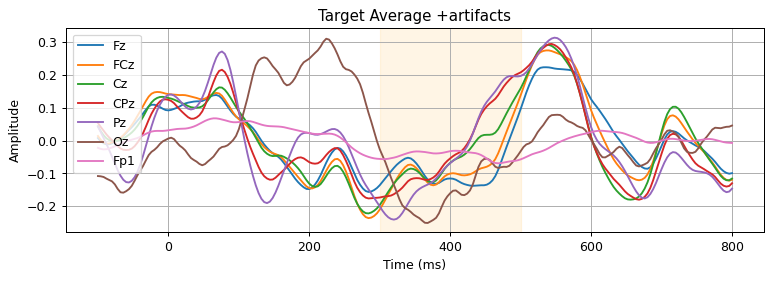

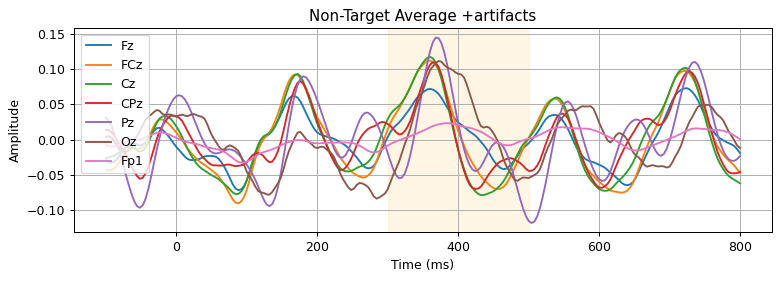

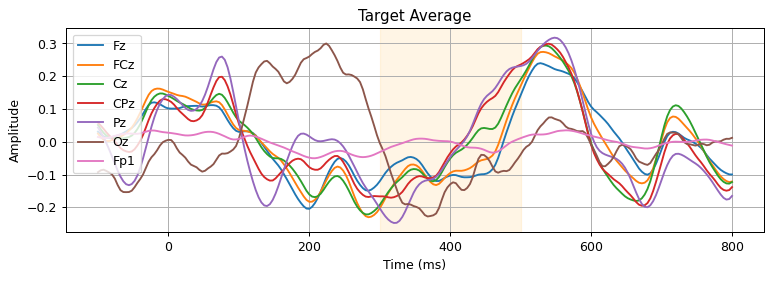

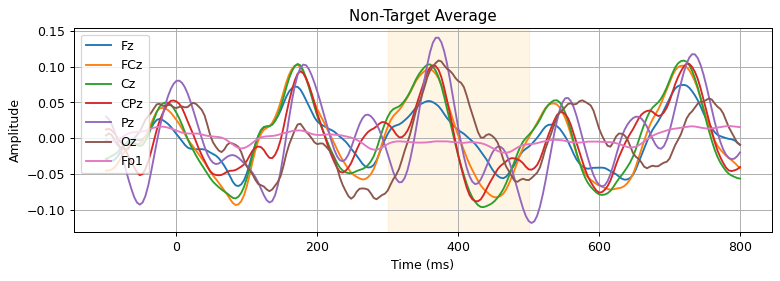

In [15]:
y = r1_events[:,2]
target_epochs = r1_epochs[y == 1]
non_target_epochs = r1_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r1_epochs.shape[1])]

target_epoch_avg = np.mean(target_epochs, axis=0)
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)

fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = channels,
    title=f'Target Average +artifacts'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = channels,
    title=f'Non-Target Average +artifacts'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

y = r1_events[picks,2]
target_epochs = r1_epochs[picks][y == 1]
non_target_epochs = r1_epochs[picks][y == 0]

print(len(target_epochs), 'target events excluding artifacts')
print(len(r1_epochs[r1_events[:,2] == 1]), 'all target events')

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r1_epochs.shape[1])]

target_epoch_avg = np.mean(target_epochs, axis=0)
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)

fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = channels,
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = channels,
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

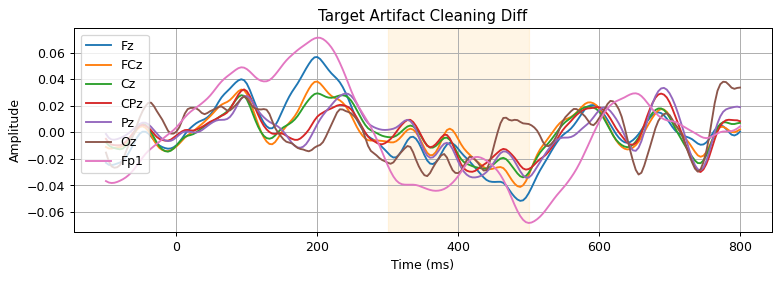

In [16]:
y = r1_events[:,2]
target_epochs = r1_epochs[y == 1]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r1_epochs.shape[1])]

y = r1_events[picks,2]
target_epochs_clean = r1_epochs[picks][y == 1]

target_epoch_avg = np.mean(target_epochs, axis=0)
target_epochs_clean_avg = np.mean(target_epochs_clean, axis=0)

diff = target_epoch_avg - target_epochs_clean_avg

fig, ax = plot_time_series(
    x_for_plot,
    diff,
    labels = channels,
    title=f'Target Artifact Cleaning Diff'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [17]:
def window_and_combine_features(epochs, sub_samples_per_ch, time_window):
    # epochs is expected to be 3D, (epoch, sample, channel)
    
    t_start = ms_to_samples(time_window[0], 250)
    t_len = ms_to_samples(time_window[1] - time_window[0], 250)
    
    window_len = np.round(t_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len + t_start
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

def balance_zeros(data, y, verbose=True):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
    if verbose:
        print(f'{100*zeros/y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part


r1_ep_mask = np.ones(len(r1_epochs), np.bool)
r1_ep_mask[r1_bad_epochs] = 0

r1_epochs_clean = r1_epochs[r1_ep_mask]
r1_y_clean = r1_y.flatten()[r1_ep_mask]
r1_events_clean = r1_events[r1_ep_mask]

# r2_ep_mask = np.ones(len(r2_epochs), np.bool)
# r2_ep_mask[r2_bad_epochs] = 0

# r2_epochs_clean = r2_epochs[r2_ep_mask]
# r2_y_clean = r2_y.flatten()[r2_ep_mask]
# r2_events_clean = r2_events[r2_ep_mask]

In [18]:
# session 1
X, y = balance_zeros(r1_epochs_clean[:,:,:-2], r1_y_clean) # remove fp1
print(X.shape)
X_windowed = window_and_combine_features(X, 7, (200, 800))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(742, 226, 5)
(742, 35)
Simple 20% test split accuracy: 0.6577181208053692


In [19]:
def test_LDA_prediction(target_ltrs, stim_labels, epochs, y, picks):
    actual = []
    prediction = []
    score = []
    for i, target_ltr in enumerate(target_ltrs):
        test_epoch = epochs[i][picks[i]]
        test_stim_labels = stim_labels[i][picks[i]]
        test_y = y[i][picks[i]]
        train_epochs = np.delete(epochs, i, 0)
        train_picks = np.delete(picks, i, 0)
        train_epochs = train_epochs[train_picks]
        train_stim_labels = np.delete(stim_labels, i, 0)
        train_stim_labels = train_stim_labels[train_picks]
        train_y = np.delete(y, i, 0)
        train_y = train_y[train_picks]
       
        train_x = train_epochs        
        train_x, train_y = balance_zeros(train_x, train_y, verbose=False)
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = LDA_clf.fit(train_x, train_y)
        
        confidence = LDA_clf.predict_proba(test_epoch)

        conf_avg = []
        for j in range(len(ltr_key)*2):
            avg = np.mean(confidence[test_stim_labels == j, 1])
            conf_avg.append(avg)
            
        conf_avg_rows = conf_avg[:len(ltr_key)]
        conf_avg_cols = conf_avg[len(ltr_key):]
        
        max_row = np.argmax(conf_avg_rows)
        max_col = np.argmax(conf_avg_cols)
        result = ltr_key[max_row][max_col]
        
#         print(f'-- Run: {i}, Results --')
#         print('training size:', train_epochs.shape[0])
#         print(f'classifier score: {LDA_clf.score(test_epoch, test_y):.2f}')
#         print(f'(row, col): ({max_row}, {max_col})')
#         print('target->', target_ltr, result, '<-prediction')
        actual.append(target_ltr)
        prediction.append(result)
        score.append(LDA_clf.score(test_epoch, test_y))
        
    avg_score = np.mean(score)
    print('    Target:', actual)
    print('Prediction:', prediction)
    print(f'Average classifier score: {avg_score*100:.2f}%')
    
shp = r1_y.shape
r1_bad_epochs_live = np.vstack((r1_bad_epochs//shp[1], r1_bad_epochs%shp[1])).T
r1_picks = np.ones(shp, bool)
r1_picks[r1_bad_epochs_live[:,0],r1_bad_epochs_live[:,1]] = 0

# remove fp1
r1_windowed = window_and_combine_features(r1_epochs[:,:,:-1], 7, (200, 600))

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])
test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    r1_picks)

    Target: ['C', 'Y', 'T', 'O', 'N', 'Z', 'E', 'R', 'O', 'P', 'H', 'A', 'S', 'E']
Prediction: ['C', 'Y', 'T', 'O', 'N', 'Z', 'E', 'R', 'P', 'P', 'H', 'A', 'S', 'E']
Average classifier score: 70.69%


---
---
# xDAWN$_{[1]}$
---

$X=DA+N$

$X \in \mathbb{R}^{N_txN_s}$ matrix of recorded EEG signals.

$N_s$ = number of sensors

$N_t$ = number of temporal samples

$A\in \mathbb{R}^{N_exN_s}$ matrix of ERP signals.

$N_e$ = number of samples corresponding to the ERP ~600 milliseconds

$D\in \mathbb{R}^{N_txN_e}$ Toeplitz $T_k$ is the stimulus onset of the $k^{th}$ target stimulus

$N$ is the ongoing activity of the user's brain including artifacts

### least square estimation of A
$\hat{A}=\underset{A}{\mathrm{argmin}}{\lVert X-DA \rVert}_2^2$

$\hat{A}=(D^T D)^{-1} D^T X$

With classical epoching of $X$ to estimate $A$ leads to<br />
$A^{*} = D^T X$

### enhanced signals are computed

$ \begin{aligned} \hat{S} &= X\hat{U} \\ &= DA' + N'R_X^{-1} \Psi_s \end{aligned}$

---
## algorithm for xDAWN , estimate evoked subspace.
---
1. Compute QR factorisation of $X \Rightarrow X = Q_X R_X$
2. Compute QR factorisation of $D \Rightarrow D = Q_D R_D$
3. Compute SVD of $Q_D^T Q_X \Rightarrow Q_D^T Q_X = \Phi \Lambda \Psi^T$
4. Select the $I$ couples of singular vectors $(\Phi_i, \Psi_i)$ associated with the $I$ largest singular values $\lambda_i$
5. Finally $\forall 1 \leq i \leq I$, $(\hat{\mathbf{u}}_i,\mathbf{a}'_i) = (R_X^{-1} \psi_i, R_D^{-1} \phi_i \lambda_i)$
6. Estimate sources: $\forall 1 \leq i \leq I$, $\hat{s}_i(t) = \hat{\mathbf{u}}_i^T \mathbf{x}(t)$
---
#### Source:
[1] Rivet, B., Souloumiac, A., Attina, V., & Gibert, G. (2009). xDAWN algorithm to enhance evoked potentials: application to brain-computer interface. IEEE transactions on bio-medical engineering, 56(8), 2035–2043. https://doi.org/10.1109/TBME.2009.2012869

In [20]:
def get_closest_ts_index(data_ts, stim_time):
    i = (np.abs(data_ts - stim_time)).argmin()
    return i

def xDAWN_org(eeg_data, eeg_data_ts, events, target_label, erp_duration, n_f):
    # data should be normalized and zeroed
    X = eeg_data
    ts = eeg_data_ts
    
    # D toeplitz of target stimuli, (n_samples, n_erps_assoc_samples) # 600 ms
    target_stim = events[events[:,2] == target_label]
    n_e = ms_to_samples(duration=erp_duration, rate=SAMPLE_RATE)
    n_t = len(X)
    first_col = np.zeros((n_t))
    target_index = [get_closest_ts_index(ts, e[0]) for e in target_stim]
    first_col[target_index] = 1
    first_row = np.zeros((n_e))
    D = linalg.toeplitz(first_col, first_row)
    
    # 1.
    Q_X, R_X = linalg.qr(X, mode='economic')
    # 2.
    Q_D, R_D = linalg.qr(D, mode='economic')
    # 3.
    phi, lam, psi = linalg.svd(Q_D.T @ Q_X, full_matrices=False)

    # 4.
    # phi, lam, and psi already sorted in decending order

    # 5.
    filters = linalg.inv(R_X) @ psi

    # 6.
    S_hat = X @ filters[:,:n_f]
    
    print(linalg.inv(R_D).shape, phi.shape, np.diag(lam).shape)
    A_prime = linalg.inv(R_D) @ phi @ np.diag(lam)
    A_hat = linalg.inv(D.T @ D) @ D.T @ X

    return S_hat, D, A_prime, A_hat


REMOVE_FP1 = True
n_f = 4 # number of filters/components

# exclude Oz and Fp1, which are the last 2 channels
ch_mask = np.ones(len(channels), np.bool)
ch_mask[-2:] = 0


# r1_runs_ev = r1_events.reshape((r1_y.shape[0], r1_y.shape[1],r1_events.shape[-1]))
# r1_picks = picks.reshape((r1_y.shape[0], r1_y.shape[1]))
# r1_runs_ev[r1_picks].shape

print(r1_events[picks].shape)

run = r1_eeg
run_ts = r1_eeg_ts
run = run[:,ch_mask]
S, D, A_prime, A_hat = xDAWN_org(run, run_ts, r1_events[picks], 1, POST_STIM, n_f)

(2261, 3)
(200, 200) (200, 5) (5, 5)


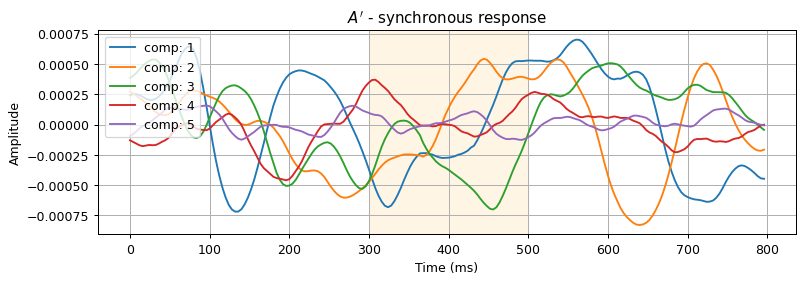

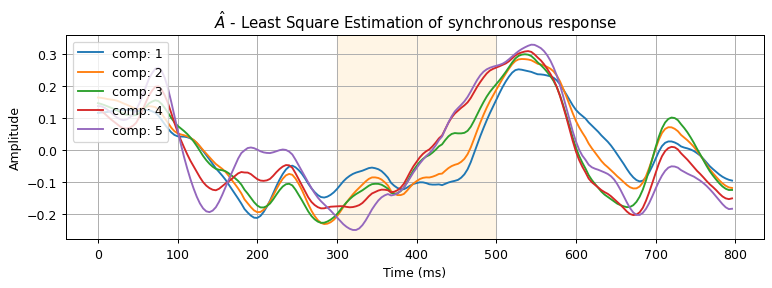

In [21]:
x_for_plot = [(i*(1000/SAMPLE_RATE)) for i in range(A_prime.shape[0])]

g_labels = [f'comp: {i+1}' for i in range(A_prime.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    A_prime,
    labels = g_labels,
    title=r"$A'$ - synchronous response"
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

x_for_plot = [(i*(1000/SAMPLE_RATE)) for i in range(A_hat.shape[0])]

g_labels = [f'comp: {i+1}' for i in range(A_hat.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    A_hat,
    labels = g_labels,
    title=r"$\hat{A}$ - Least Square Estimation of synchronous response"
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

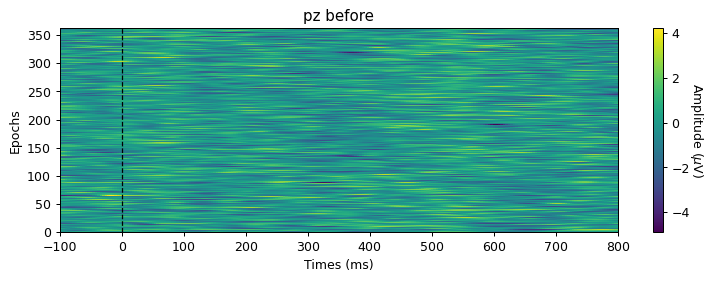

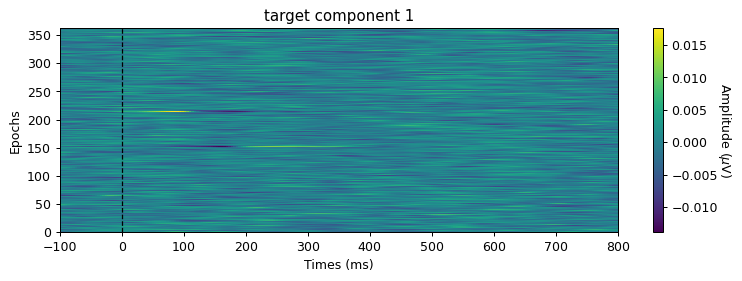

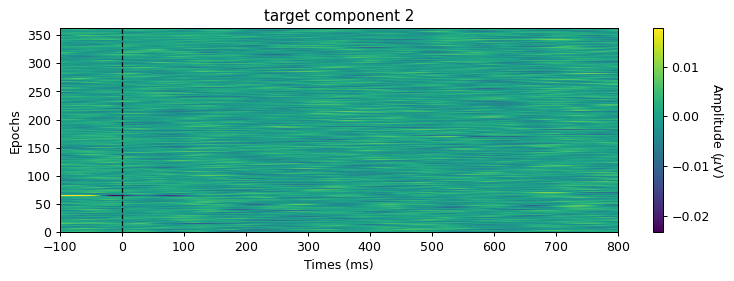

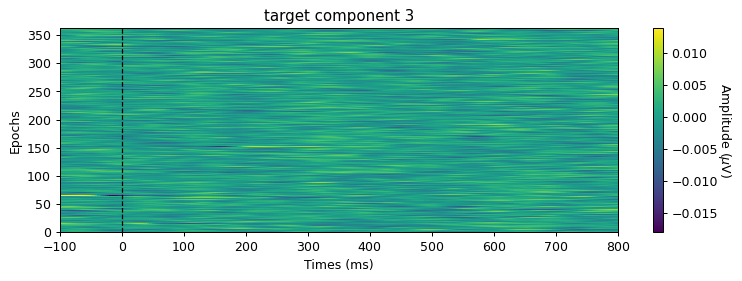

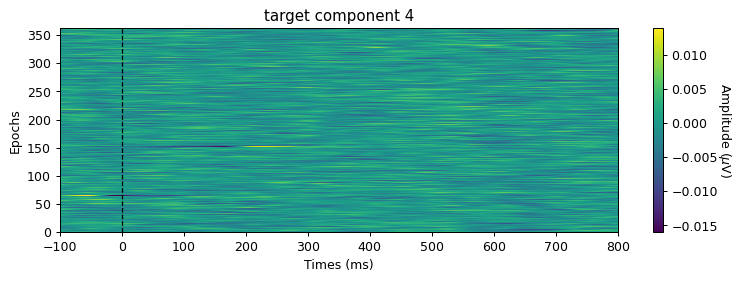

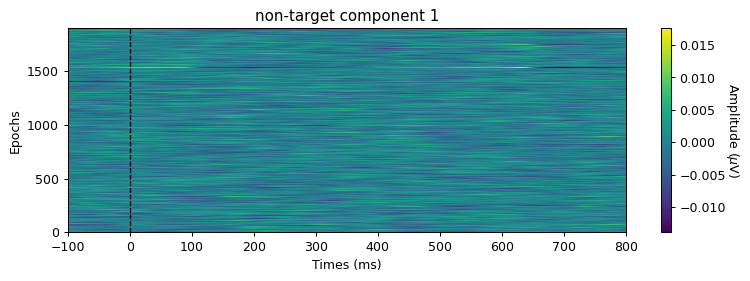

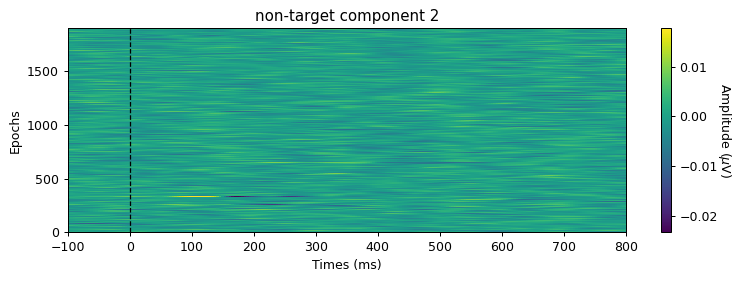

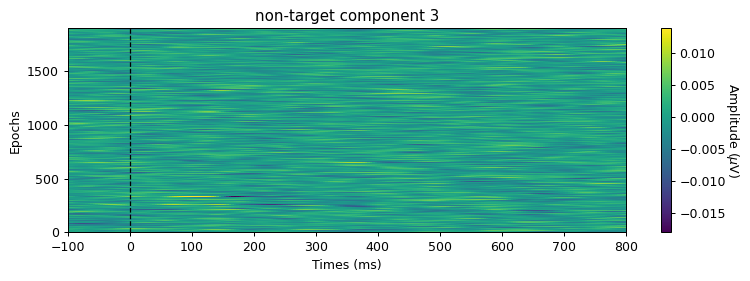

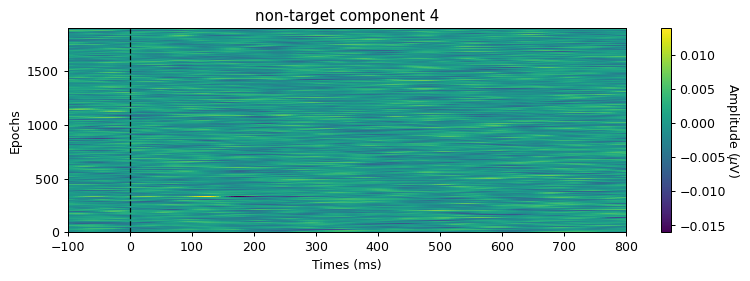

In [22]:
s_epochs = []
for event in r1_events:
    epoch = get_epoch(S, run_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)

s_epochs = np.array(s_epochs)

# pz before
plot_epochs(r1_epochs[picks][r1_events[picks,2] == 1,:,pz], title=f'pz before', tmin=-100, tmax=800)


target_s_epochs = s_epochs[picks][r1_events[picks,2] == 1]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(target_s_epochs[:,:,i], title=f'target component {i+1}', tmin=-100, tmax=800)
    
nontarget_s_epochs = s_epochs[picks][r1_events[picks,2] == 0]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(nontarget_s_epochs[:,:,i], title=f'non-target component {i+1}', tmin=-100, tmax=800)

In [23]:
shp = r1_y.shape
picks_live = picks.reshape(shp)

r1_windowed = window_and_combine_features(s_epochs, 7, (200, 600))

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])

test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    picks_live)

    Target: ['C', 'Y', 'T', 'O', 'N', 'Z', 'E', 'R', 'O', 'P', 'H', 'A', 'S', 'E']
Prediction: ['S', 'Y', 'T', '5', '6', 'Z', 'E', 'R', 'Q', 'P', 'I', 'S', 'S', 'D']
Average classifier score: 61.64%


In [24]:
s_epochs_clean = s_epochs[picks]
r1_y_clean = r1_y.flatten()[picks]
r1_events_clean = r1_events[picks]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=24)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(742, 226, 4)
(742, 28)
Simple 20% test split accuracy: 0.5704697986577181


### again

In [25]:
def reg_covariance(data, assume_centered = True):
    # data should be of shape (n_t, n_c)
    rank = np.linalg.matrix_rank(data)

    C = data.T @ data # watch the data shape, could be data.T * data

    # whitening ... PCA
    eig, eigvec = np.linalg.eigh(C)
    eigvec = eigvec.conj().T
    mask = np.ones(len(eig), bool)
    
    eig[:-rank] = 0.0
    mask[:-rank] = False
    
    eigvec = eigvec[mask]
    data_eig = data @ eigvec
    
    # compute 'empirical' covariance
    X = data_eig.copy()
    
    if X.ndim == 1:
        X = np.reshape(X, (1,-1))

    if X.shape[0] == 1:
        warnings.warn("Only one sample available. "
                      "You may want to reshape your data array")

    if assume_centered:
        covariance = np.dot(X.T, X) / X.shape[0]
    else:
        covariance = np.cov(X.T, bias=1)
        
    # project back
    covariance = eigvec.T @ (covariance @ eigvec)
    # undo bias
    covariance *= data.shape[0]/(data.shape[0] - 1)
    
    return covariance

def build_toeplitz(data, data_ts, events, n_e, pre_stim_time = 0):
    # data = (n_t,n_c)
    # n_e = samples in a ERP...epoch length
    n_t = data.shape[0]
    
    toeplitz = []
    stim_type = np.unique(events[:,2])
    n_minus = ms_to_samples(pre_stim_time, SAMPLE_RATE)
    for stim in stim_type:
        sel = events[:,2] == stim
        first_col = np.zeros((n_t))
        stim_pos_index = [get_closest_ts_index(data_ts, e[0]) for e in events[sel]]
        first_col[stim_pos_index] = 1
        first_row = np.zeros((n_e))
        toeplitz.append(linalg.toeplitz(first_col, first_row))
        
    toeplitz = np.hstack(toeplitz)
    return toeplitz

class xDAWN:
    def __init__(self, X, X_ts, events, erp_sample_size=800, sample_rate=250, use_reg_cov=False):
        self.X = X
        self.X_ts = X_ts
        self.events = events
        self.n_e = ms_to_samples(erp_sample_size, sample_rate)
        
        # toeplitz
        D = build_toeplitz(self.X, self.X_ts, self.events, self.n_e)

        # least square est
        P = linalg.inv(D.T @ D) @ D.T @ X
        
        classes = np.unique(events[:,2])
        P = (np.vsplit(P, len(classes)))
        D = np.hsplit(D, len(classes))
        
        # plot patterns
#         x_for_plot = [(i*(1000/SAMPLE_RATE)) for i in range(P[0].shape[0])]
#         comp_labels = [f'comp: {p+1}' for p in range(P[0].shape[1])]
        
#         fig, ax = plot_time_series(
#             x_for_plot,
#             P[0],
#             labels = comp_labels,
#             xlabel='Time (ms)',
#             ylabel=r'Amplitude ($\mu$V)',
#             title=f'Pattern for Targets'
#         )
#         _ = ax.axvspan(300, 500, color='orange', alpha=0.1)
        
#         fig, ax = plot_time_series(
#             x_for_plot,
#             P[1],
#             labels = comp_labels,
#             xlabel='Time (ms)',
#             ylabel=r'Amplitude ($\mu$V)',
#             title=f'Pattern for Non-Targets'
#         )
#         _ = ax.axvspan(300, 500, color='orange', alpha=0.1)


        # compute whitening covariance for the raw signal
        if use_reg_cov:
            sig_cov = reg_covariance(self.X)
        else:
            sig_cov = (self.X.T @ self.X) / (len(self.X)-1)

        
        filters = []
        patterns = []
        # we can select the components when filtering
        all_components = self.X.shape[1]
        for P_i, D_i in zip(P, D):

            # estimate cov matrix of prototype
            if use_reg_cov:
                evo = D_i @ P_i
                evo_cov = reg_covariance(evo)
            else:
                DP_i = P_i.T @ D_i.T @ D_i @ P_i
                evo_cov = DP_i / (len(self.X)-1)

            try:
                e_vals, e_vecs = linalg.eigh(evo_cov, sig_cov)
            except np.linalg.LinAlgError as exp:
                print('FAIL')

            e_vecs = e_vecs[:, np.argsort(e_vals)[::-1]]  # sort eigenvectors
            e_vecs /= np.apply_along_axis(np.linalg.norm, 0, e_vecs)

            _patterns = np.linalg.pinv(e_vecs)

            filters.append(e_vecs[:, :all_components])
            patterns.append(_patterns[:, :all_components])
        
        self.filters = np.array(filters)
        self.patterns = np.array(patterns)
        
    def transform(self, X, n_f = 3):
        print(self.filters.shape)
        if self.filters.shape[1] != X.shape[1]:
            print('Channels and filters don\'t match. No transform performed.')
            return X

        x_enhanced = X @ self.filters[0][:,:n_f]
    
        return x_enhanced
    
    def inverse_transform(self, trans_X):
        # trans_X should be (n_t, n_f)
        n_f = trans_X.shape[1]
        
        xfiltered = trans_X @ self.patterns[0][:n_f,:]
    
        return xfiltered
    
    def counter_transform(self, X, n_f=3):

        x_enhanced = X @ self.filters[1][:,:n_f]
        xfiltered = x_enhanced @ self.patterns[1][:,:n_f].T
    
        return xfiltered
    
    
r1_data = r1_eeg[:,ch_mask]
r1_data_ts = r1_eeg_ts
print('org:', r1_data.shape)
r1_xdawn = xDAWN(r1_data, r1_data_ts, r1_events, 800, use_reg_cov=True)
r1_filtered = r1_xdawn.transform(r1_data, 3)
r1_rebuilt = r1_xdawn.inverse_transform(r1_filtered)
print('rebuilt:', r1_rebuilt.shape)
r1_rebuilt_c = r1_xdawn.counter_transform(r1_data, 4)
print(r1_filtered.shape, r1_rebuilt.shape)

org: (156974, 5)
(2, 5, 5)
rebuilt: (156974, 5)
(156974, 3) (156974, 5)


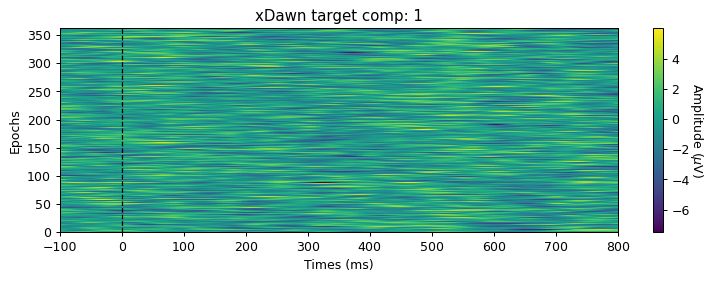

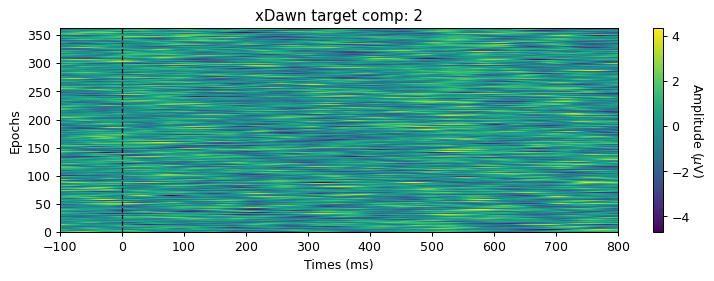

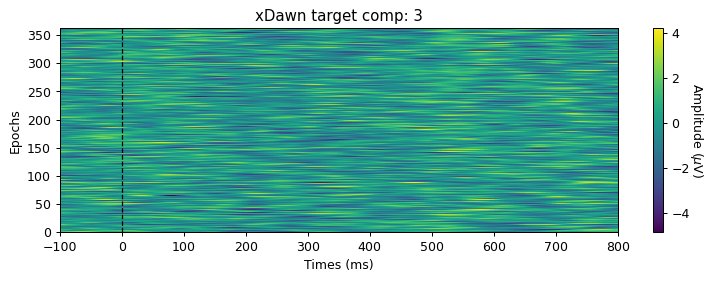

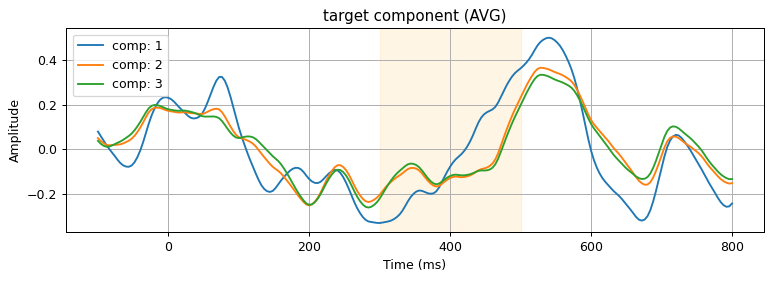

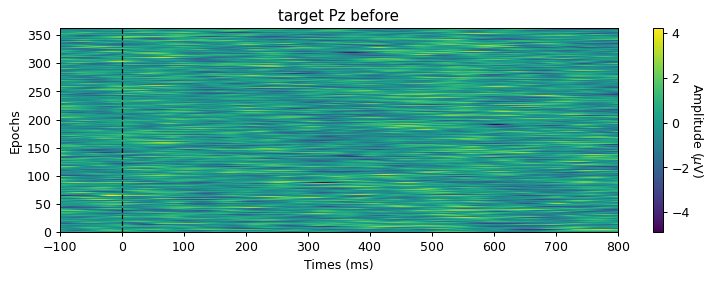

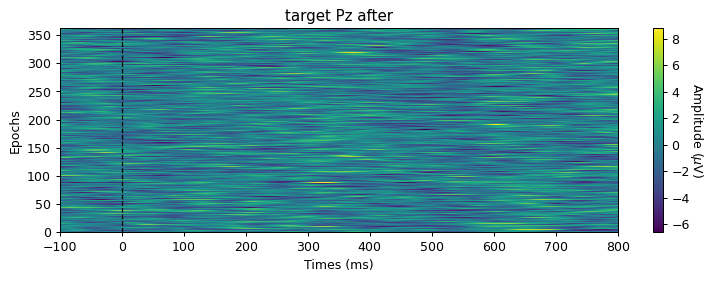

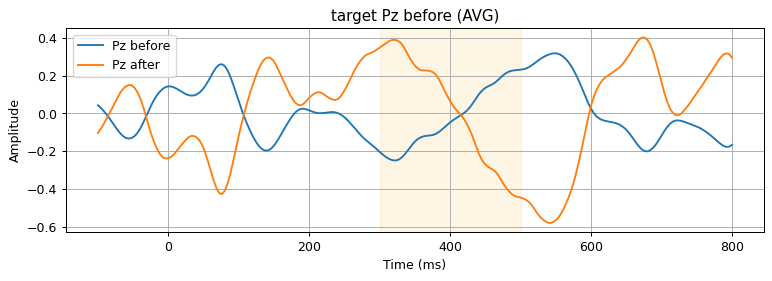

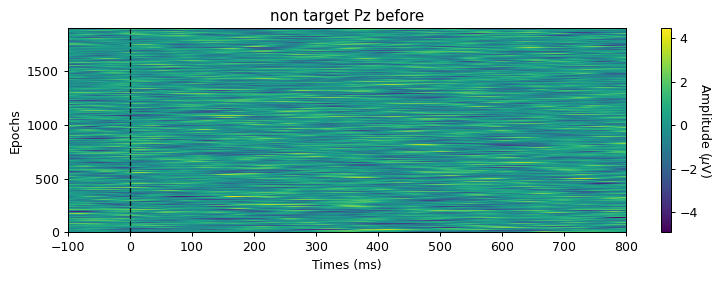

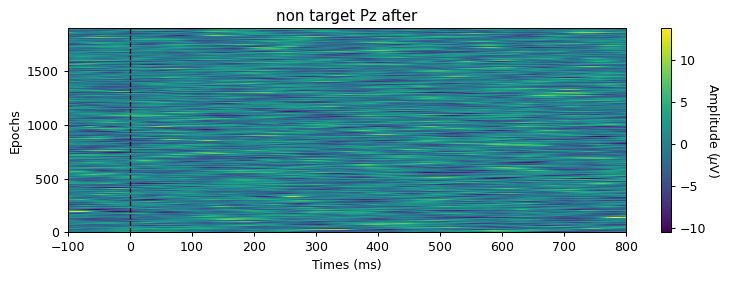

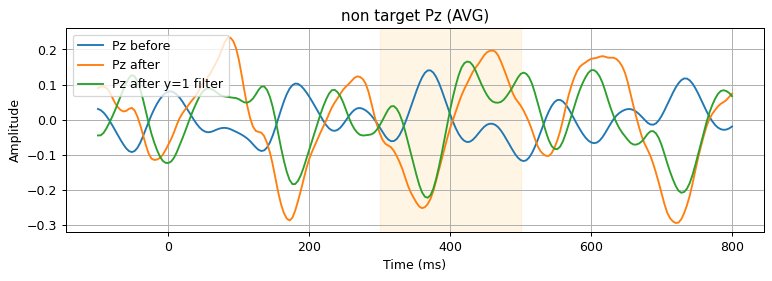

In [26]:
s_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_filtered, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
target_s_epochs = s_epochs[picks][r1_events[picks,2] == 1]
nontarget_s_epochs = s_epochs[picks][r1_events[picks,2] == 0]

s_target_avg = []
for i in range(r1_filtered.shape[1]):
    plot_epochs(target_s_epochs[:,:,i], title=f'xDawn target comp: {i+1}', tmin=-100, tmax=800)
#     plot_epochs(nontarget_s_epochs[:,:,i], title=f'xDawn non-target comp: {i+1}', tmin=-100, tmax=800)
    s_target_avg.append(target_s_epochs[:,:,i].mean(axis=0))
    
x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(s_epochs.shape[1])]
g_labels = [f'comp: {i+1}' for i in range(r1_filtered.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    np.array(s_target_avg).T,
    labels = g_labels,
    title=f'target component (AVG)'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)
    
    
p_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_rebuilt, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    p_epochs.append(epoch)
    
p_epochs = np.array(p_epochs)
_ = plot_epochs(target_epochs[picks[r1_events[:,2] == 1],:,pz], title=f'target Pz before', tmin=-100, tmax=800)   
_ = plot_epochs(p_epochs[picks][r1_events[picks,2] == 1,:,pz], title=f'target Pz after', tmin=-100, tmax=800)   
    
    
x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(p_epochs.shape[1])]
# print(len(x_for_plot))
b_Pz = target_epochs_clean[:,:,pz].mean(axis=0)
b_Pz = b_Pz[None].T
a_Pz = p_epochs[picks][r1_events[picks,2] == 1,:,pz].mean(axis=0)
a_Pz = a_Pz[None].T
for_plot = np.hstack((b_Pz, a_Pz))


# g_labels = [f'comp: {i+1}' for i in range(A.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    for_plot,
    labels = ['Pz before', 'Pz after'],
    title=f'target Pz before (AVG)'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)


c_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_rebuilt_c, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    c_epochs.append(epoch)
    
c_epochs = np.array(c_epochs)
_ = plot_epochs(r1_epochs[picks][r1_events[picks,2] == 0,:,pz], title=f'non target Pz before', tmin=-100, tmax=800)   
_ = plot_epochs(c_epochs[picks][r1_events[picks,2] == 0,:,pz], title=f'non target Pz after', tmin=-100, tmax=800)   
    
    
x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(c_epochs.shape[1])]
# print(len(x_for_plot))
b_Pz = r1_epochs[picks][r1_events[picks,2] == 0,:,pz].mean(axis=0)
b_Pz = b_Pz[None].T
a_Pz = c_epochs[picks][r1_events[picks,2] == 0,:,pz].mean(axis=0)
a_Pz = a_Pz[None].T
c_Pz = p_epochs[picks][r1_events[picks,2] == 0,:,pz].mean(axis=0)
c_Pz = c_Pz[None].T
for_plot = np.hstack((b_Pz, a_Pz, c_Pz))


# g_labels = [f'comp: {i+1}' for i in range(A.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    for_plot,
    labels = ['Pz before', 'Pz after', 'Pz after y=1 filter'],
    title=f'non target Pz (AVG)'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [27]:
s_epochs_clean = s_epochs[picks]
r1_y_clean = r1_y.flatten()[picks]
r1_events_clean = r1_events[picks]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(742, 226, 3)
(742, 21)
Simple 20% test split accuracy: 0.6510067114093959


In [28]:
r1_xdawn = xDAWN(r1_data, r1_data_ts, r1_events[picks], 800, use_reg_cov=True)
r1_filtered = r1_xdawn.transform(r1_data, 4)
r1_filtered.shape


s_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_filtered, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
# target_s_epochs = s_epochs[picks][r1_events[picks,2] == 1]
# nontarget_s_epochs = s_epochs[picks][r1_events[picks,2] == 0]

s_epochs_clean = s_epochs[picks]
r1_y_clean = r1_y.flatten()[picks]
r1_events_clean = r1_events[picks]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=50)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

(2, 5, 5)
83.99% zeros
(742, 226, 4)
(742, 28)
Simple 20% test split accuracy: 0.6577181208053692


(200, 5)
(362, 200, 5) (200, 5)


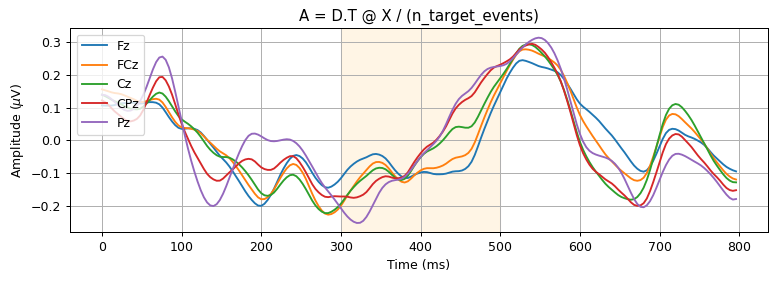

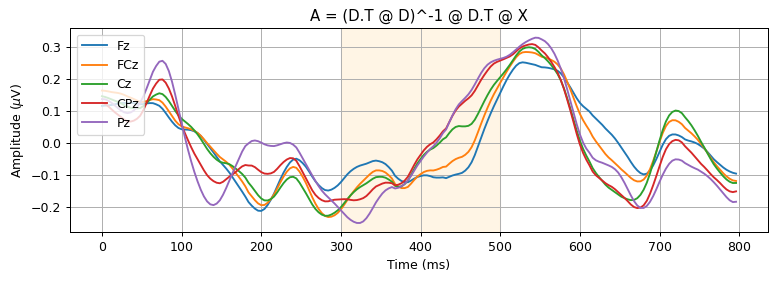

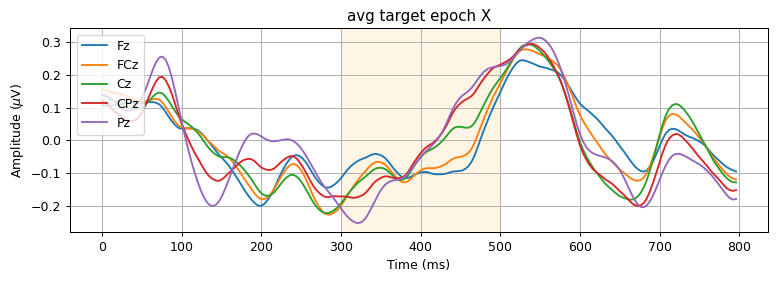

In [29]:
X = r1_eeg[:,:-2]
stim = r1_events[picks]

target_stim = stim[stim[:,2] == 1]
n_e = ms_to_samples(duration=800, rate=SAMPLE_RATE)
n_t = len(X)
first_col = np.zeros((n_t))
target_index = [get_closest_ts_index(r1_eeg_ts, e[0]) for e in target_stim]
first_col[target_index] = 1
first_row = np.zeros((n_e))
D = linalg.toeplitz(first_col, first_row)

A = D.T @ X
A_hat = linalg.inv(D.T @ D) @ D.T @ X
print(A.shape)
x_for_plot = [(i*(1000/SAMPLE_RATE)) for i in range(A.shape[0])]

# g_labels = [f'comp: {i+1}' for i in range(A.shape[1])]
fig, ax = plot_time_series(
    x_for_plot,
    A/len(target_stim),
    labels = channels[:-2],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'A = D.T @ X / (n_target_events)'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

fig, ax = plot_time_series(
    x_for_plot,
    A_hat,
    labels = channels[:-2],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'A = (D.T @ D)^-1 @ D.T @ X'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

quick_epoch = []
for event in stim[stim[:,2] == 1]:
    epoch = get_epoch(X, r1_eeg_ts, event[0], 0, POST_STIM-4, SAMPLE_RATE)
    quick_epoch.append(epoch)
    
quick_epoch = np.array(quick_epoch)
avg_X = quick_epoch.mean(axis=0)
print(quick_epoch.shape, avg_X.shape)

fig, ax = plot_time_series(
    x_for_plot,
    avg_X,
    labels = channels[:-2],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'avg target epoch X'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

(156974, 5) (5, 4)


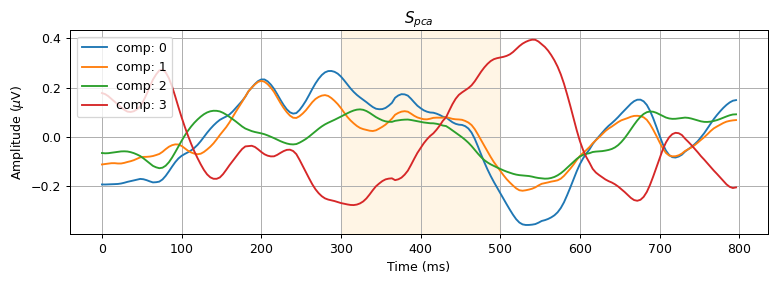

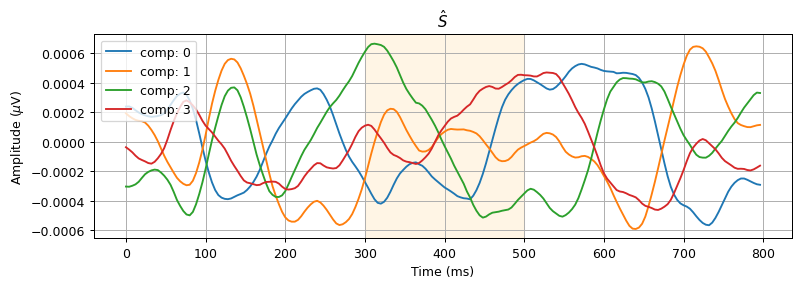

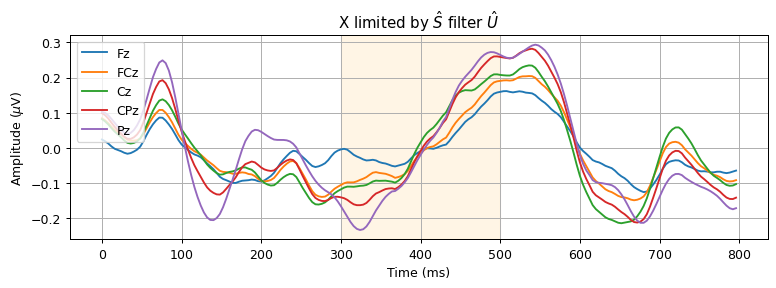

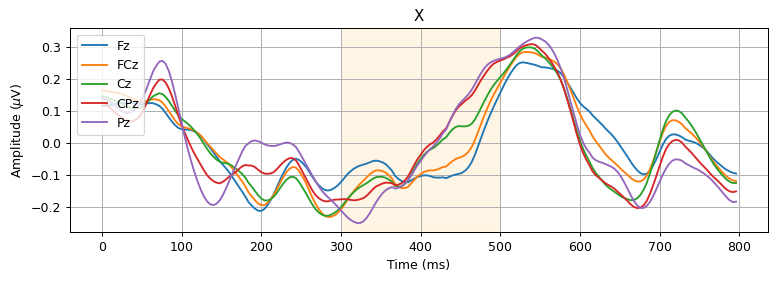

In [30]:
n_f = 4

A_hat = linalg.inv(D.T @ D) @ D.T @ X
sigma, delta, pi = linalg.svd(A_hat, full_matrices=False)
u_pca = pi[:,:n_f]
print(X.shape, u_pca.shape)
s_pca = X @ u_pca

s_pca_plot = linalg.inv(D.T @ D) @ D.T @ s_pca

s_pca_labels = [f'comp: {comp}' for comp in range(s_pca_plot.shape[1])]

fig, ax = plot_time_series(
    x_for_plot,
    s_pca_plot,
    labels = s_pca_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=r'$S_{pca}$'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

# ========================

Q_X, R_X = linalg.qr(X, mode='economic')
Q_D, R_D = linalg.qr(D, mode='economic')
phi, lam, psi = linalg.svd(Q_D.T @ Q_X, full_matrices=False)

filters = linalg.inv(R_X) @ psi

# 6. below matches the algo, but X @ filters[:,:n_f] would also work
S_hat = filters[:,:n_f].T @ X.T
S_hat = S_hat.T

S_hat_rebuilt = S_hat @ linalg.inv(filters)[:n_f, :]

s_hat_plot = linalg.inv(D.T @ D) @ D.T @ S_hat

s_hat_labels = [f'comp: {comp}' for comp in range(s_hat_plot.shape[1])]

fig, ax = plot_time_series(
    x_for_plot,
    s_hat_plot,
    labels = s_pca_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=r'$\hat{S}$'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)


S_hat_rebuilt_plot = linalg.inv(D.T @ D) @ D.T @ S_hat_rebuilt

fig, ax = plot_time_series(
    x_for_plot,
    S_hat_rebuilt_plot,
    labels = channels[:S_hat_rebuilt.shape[1]],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=r'X limited by $\hat{S}$ filter $\hat{U}$ '
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

Y_plot = linalg.inv(D.T @ D) @ D.T @ X

fig, ax = plot_time_series(
    x_for_plot,
    Y_plot,
    labels = channels[:X.shape[1]],
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=r'X'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

1.000006370522327 0.6491592904676796
2.032113341655047 -1.3923652205116457


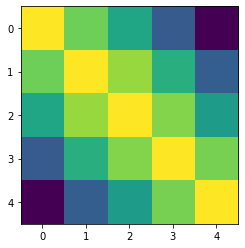

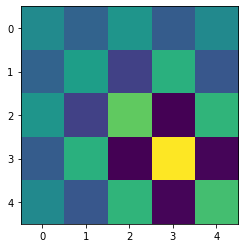

In [33]:
C = (X.T@X)/(len(X) - 1)
C_reg = reg_covariance(X, assume_centered=True)

print(np.max(C),np.min(C))
print(np.max(C_reg),np.min(C_reg))

fig_cor, axes_cor = plt.subplots(1,1)
# fig_cor.set_size_inches(6, 6)
axes_cor.imshow(C)
# axes_cor.colorbar()
plt.draw()


fig_cor, axes_cor = plt.subplots(1,1)
# fig_cor.set_size_inches(6, 6)
axes_cor.imshow(C_reg)
# axes_cor.colorbar()
plt.draw()